This notebook contains the code needed to execute the experiments for regular binary Classification datasets, namely misclassification rate and retention rate for deltas

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data_utils
import warnings
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore", category=UserWarning) # Prevents Tanh warning messages 

Scaler = StandardScaler()


In [2]:
def create_xy(dataset, attribute_columns, target_column, delim, split_ratio,ditch_head=False):
    with open(dataset, 'r') as f:
        lines = f.readlines()
    if ditch_head:
        lines = lines[1:]
    X = []
    Y = []
    for line in lines:
        while len(line) > 0 and line[-1] == "\n":
            line = line[:len(line)-1]
        split_array = line.split(delim)
        all_columns = []
        for value in split_array:
            if value !="" and value !=" ":
                all_columns.append(value)
        if len(all_columns)==0:
            break
        point = []
        for i in attribute_columns:
            point.append(float(all_columns[i]))
        try:
            Y.append(float(all_columns[target_column]))
            X.append(point)
        except:
            pass
    X_arr = np.asarray(X)
    Scaler.fit(X_arr)
    X_arr = Scaler.transform(X_arr)
    Y_arr = np.asarray(Y)
    thresh = np.median(Y_arr)
    Y_arr_binary = np.where(Y_arr<=0,0,1) # Target columns are binary anyway
    unique, counts = np.unique(Y_arr_binary, return_counts=True)
    x_train, x_test, y_train, y_test = train_test_split(X_arr, Y_arr_binary, test_size = split_ratio)
    return x_train, x_test, y_train, y_test, Y_arr, X_arr, Y_arr_binary

In [3]:
torch.manual_seed(111)
class Network(nn.Module):
    def __init__(self, indim):
        super(Network,self).__init__()
        self.l1 = nn.Linear(indim,100)
        self.l2 = nn.Linear(100,50)
        self.l3 = nn.Linear(50,9)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = self.l3(x)
        return x


In [4]:
# Loss and Accuracy Computation functions

def cumLaplaceDistribution(y_pred,mean,standard_deviation,all_qs):
    term1 = ((1-all_qs) * (y_pred - mean))/standard_deviation
    term1.clamp_(max = 0) # Prevents NaN - Only one of term 1 or 2 is used, whichever is -ve
    lesser_term = all_qs * torch.exp(term1)
    term2 = (-1.0 * all_qs * (y_pred - mean))/standard_deviation
    term2.clamp_(max = 0) # Again, Prevents NaN
    greater_term = 1 - ((1-all_qs) * torch.exp(term2))
    mean_tensor = torch.ones_like(mean)
    y_mask = torch.div(y_pred,mean_tensor)
    y_mask[y_pred >= mean] = 1.0
    y_mask[y_pred < mean] = 0.0
    return ((1 - y_mask) * lesser_term )+  (y_mask * greater_term)


def logLikelihoodLoss(y_true,y_pred,mean,standard_deviation,all_qs):
    new_pred = y_pred
    prob = cumLaplaceDistribution(0.0,mean = new_pred,
                                  standard_deviation = standard_deviation,all_qs = all_qs)
    prob.clamp_(min = 1e-7,max = 1 - 1e-7)
    if_one = y_true * torch.log(1 - prob)
    if_zero = (1 - y_true) * torch.log(prob)
    final_loss = - 1 * torch.mean(if_one + if_zero)
    return final_loss

def customLoss(y_true, y_pred, mean, standard_deviation, all_qs, penalty):
    ind_losses = []
    for i,j in enumerate(all_qs):
        single_quantile_loss = logLikelihoodLoss(y_true[:,0],y_pred[:,i] ,
                                                 mean, standard_deviation, j)
        ind_losses.append(single_quantile_loss)
    zero = torch.Tensor([0]).to(device)
    dummy1 = y_pred[:,1:] - y_pred[:,:-1]
    dummy2 = penalty * torch.mean(torch.max(zero,-1.0 * dummy1))
    total_loss  = torch.mean(torch.stack(ind_losses)) +dummy2
    return total_loss

def customTestPred(y_pred,mean,standard_deviation,all_qs,batch_size = 1):
    acc = []
    cdfs = []
    val = (y_pred - mean)/standard_deviation 
    
    for xx in range(batch_size):
        if(y_pred < mean[xx]):
            lesser_term = all_qs * torch.exp((1.0 - all_qs) * torch.tensor(val[xx], dtype=torch.double)) 
            # Typecast above needed for some versions of torch
            lesser_term  = 1 - lesser_term
            cdfs.append(lesser_term.item())
            if(lesser_term.item() >= 0.5):
                acc.append([1])
            else:
                acc.append([0])
        
        elif(y_pred >= mean[xx]):
            greater_term = 1.0 - ((1.0-all_qs) * torch.exp(-1.0 * all_qs * torch.tensor(val[xx], dtype=torch.double)))
            # Typecast above needed for some versions of torch
            greater_term = 1 - greater_term
            cdfs.append(greater_term.item())
            if(greater_term.item() >= 0.5):
                acc.append([1])
            else:
                acc.append([0])
    return torch.Tensor(acc).to(device).reshape(-1,1),torch.Tensor(cdfs).to(device).reshape(-1,1)

def acc_tests(test_preds,test_labels):
    test_preds = np.array(test_preds).reshape(-1,1)
    test_labels = np.array(test_labels).reshape(-1,1)
    cdfs_acc,_ = customTestPred(0,test_preds,standard_deviation = 1,all_qs = torch.Tensor([0.5]),
                                batch_size = test_preds.shape[0])

    count = 0
    for i,j in zip(cdfs_acc,test_labels):
        if(i.item() == j[0]):
            count += 1
    return count/test_labels.shape[0]

In [5]:
# Training and Testing Methods

def train(model,loader,epochs, verbose=False):
    train_preds_Q = []
    train_labels = []
    model.train()
    
    for i,j in enumerate(loader):
        inputs,labels = j[0],j[1]
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        op_qs = model(inputs)
        lossQ = customLoss(labels.reshape(-1,1),op_qs, mean_is,std_is,all_qs,penalty)
        lossQ.backward()
        optimizer.step()
        
        for lag in op_qs[:,4].detach().reshape(-1,1):
            train_preds_Q.append(lag.item())
        for lag in labels.reshape(-1,1):
            train_labels.append(lag.item())
            
    acc_is_Q = acc_tests(train_preds_Q,train_labels)
    
    if verbose:
        print("[%d/%d] Train Acc Q : %f "%(epochs,total_epochs,acc_is_Q))
    return acc_is_Q

def test(model,loader,epochs,verbose=False):
    model.eval()
    test_preds_Q = []
    test_preds_bce = []
    test_labels = []
    with torch.no_grad():
        for i,j in enumerate(loader):
            inputs,labels = j[0],j[1]
            inputs = inputs.to(device)
            labels = labels.to(device)
            op_qs = model(inputs)
            
            for lag in op_qs[:,4].detach().reshape(-1,1):
                test_preds_Q.append(lag.item())
            for lag in labels.reshape(-1,1):
                test_labels.append(lag.item())
                
    acc_is_Q = acc_tests(test_preds_Q,test_labels)
    
    if verbose:
        print("[%d/%d] Test Acc Q : %f  "%(epochs,total_epochs,acc_is_Q))
    return acc_is_Q

In [6]:
def quantileCDF(x, tau):
    if x>0:
        return 1 - tau*np.exp((tau-1)*x)
    else:
        return (1 - tau)*np.exp(tau*x)

In [7]:
batch_is = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.deterministic=True
print("Torch Device:",device)
torch.set_default_dtype(torch.double)

Torch Device: cpu


In [8]:
# General Control Parameters for the Quantile loss. Need not be changed
lr_is = 1e-2
mean_is = 0
std_is = 1
penalty = 1
alpha = 0.0

# Tau tensor
all_qs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
all_qs = torch.Tensor(all_qs).to(device)
all_qs = all_qs.double()

In [9]:
# Adjust the dataset details here. Refer the dataset_params.txt file for the specifics of each dataset
dataset = '../Datasets/Classification/pima.csv'
x_cols = list(range(8))
y_col = 8
separator = ","
remove_head = True
split_ratio = 0.2

In [10]:
# Experiment Control Parameters
total_runs = 10    # Number of times to run the experiment
total_epochs = 20  # No of training epochs per run
verbosity = False  # Toggle verbose training

In [11]:
total_acc = []
misc_delta = [[0 for k in range(total_runs)] for i in range(5)]
misc_total = [[0 for k in range(total_runs)] for i in range(5)]
accept_total = [[0 for k in range(total_runs)] for i in range(5)]

data_for_auc = False
samples_per_conf_level =[[] for i in range(5)]
preds_per_conf_level =[[] for i in range(5)]

cov_dataset_generated = False

for iter in range(total_runs):
    print("Iteration:", iter+1)
    
    X_train,X_val,y_train,y_val, data_Y, data_X, all_classes = create_xy(dataset, x_cols, y_col, separator, 0.2,remove_head)
    X_train = torch.Tensor(X_train)
    y_train = torch.Tensor(y_train)
    X_val = torch.Tensor(X_val)
    y_val = torch.Tensor(y_val)
    
    train_dataset = data_utils.TensorDataset(X_train, y_train)
    test_dataset = data_utils.TensorDataset(X_val, y_val)
    train_loader = data_utils.DataLoader(train_dataset, batch_size =128, pin_memory=True,shuffle=True,num_workers = 1)
    test_loader = data_utils.DataLoader(test_dataset,batch_size =512,pin_memory=True,shuffle = False,num_workers = 1)
    
    # This generates the coverage dataset to check the overall delta scores
    # Needs to be generated only once
    if not cov_dataset_generated:  
        X_cov = torch.Tensor(data_X)
        y_cov = torch.Tensor(data_Y)
        cov_dataset = data_utils.TensorDataset(X_cov, y_cov)
        cov_loader = data_utils.DataLoader(cov_dataset, batch_size = 512, pin_memory=True,shuffle=False,num_workers = 1)
        cov_dataset_generated = True
    
    indim = X_train.shape[1]
    model = Network(indim)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr_is)
    
    for epoch in range(total_epochs):
        acc_train = train(model,train_loader,epoch, verbosity)
        acc_test = test(model,test_loader,epoch,verbosity)
        
    with torch.no_grad():
        all_preds = [[] for i in range(9)]
        test_labels = []
        
        for i,j in cov_loader:
            inputs,labels = i.to(device),j.to(device)
            op_qs = model(inputs)
            
            for itemset in op_qs.detach():
                for quant in range(9):
                    all_preds[quant].append(itemset[quant].item())
            for lag in labels.reshape(-1,1):
                test_labels.append(lag.item())
                
    delta_total = [0,0,0,0,0]
    delta_misc = [0,0,0,0,0]
    rms_sum = 0
    correct_counter = 0
    for i in range(len(data_Y)):
        start = 4
        left = start
        right = start
        found = False
        count = 0
        medprob = quantileCDF(all_preds[start][i], 0.5)
        while (left>-1 and not found):
            q_left = all_preds[left][i]
            q_right = all_preds[right][i]
            p_left = quantileCDF(q_left, 0.5)
            p_right = quantileCDF(q_right, 0.5)
            left -=1
            right +=1
            if (q_left <= 0.5 and q_right>=0.5):
                found = True
            else:
                count +=1
                
        delta_total[count-1] +=1
        for temp in range(5):
            if count-1>=temp:
                accept_total[temp][iter] +=1
                
        if (data_Y[i]==0 and medprob<=0.5) or (data_Y[i]==1 and medprob>0.5):
            correct_pred = True
            correct_counter += 1
        else:
            correct_pred = False
        if not correct_pred:
            delta_misc[count-1] +=1
        if not data_for_auc:
            samples_per_conf_level[count-1].append(data_Y[i])
            preds_per_conf_level[count-1].append(medprob)
    
    if not data_for_auc:
        data_for_auc = True
    
    total_acc.append(correct_counter/len(data_Y))
    for i in range(5):
        misc_delta[i][iter] = delta_misc[i]
        misc_total[i][iter] = delta_total[i]


Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10


In [12]:
print("Accuracy : {:.2f} +/- {:.2f}".format(np.mean(total_acc), np.std(total_acc)))

Accuracy : 0.81 +/- 0.01


In [13]:
# Delta based results - Misclassification Rate and Retention Rate

misc_rate_results = "Misc. Rate |"
delta_header      = "Delta      |"
ret_rate_results  = "Ret.  Rate |"

for i in range(5):
    delta_header += "{:.2f}".format(0.1*(i+1)) + " | "
    total_samples = sum(misc_total[i])
    total_misc = sum(misc_delta[i])
    v2sum = 0
    for j in range(len(misc_total[i])):
        if misc_total[i][j] != 0:
            v2sum += misc_delta[i][j] /misc_total[i][j] 
    v2ratio = v2sum/len(misc_total[i])
    misc_rate_results += "{:.2f}".format(v2ratio) + " | "

print("Misclassification vs Delta Results:")
print(delta_header)
print(misc_rate_results)

print()

print("Retention Rate vs Delta Results:")
print(delta_header)
for ret_rate in accept_total:
    ret_rate_results += "{:.2f}".format(np.mean(ret_rate)/len(data_Y)) + " | "
print(ret_rate_results)


Misclassification vs Delta Results:
Delta      |0.10 | 0.20 | 0.30 | 0.40 | 0.50 | 
Misc. Rate |0.41 | 0.37 | 0.29 | 0.16 | 0.05 | 

Retention Rate vs Delta Results:
Delta      |0.10 | 0.20 | 0.30 | 0.40 | 0.50 | 
Ret.  Rate |1.00 | 0.89 | 0.76 | 0.60 | 0.40 | 


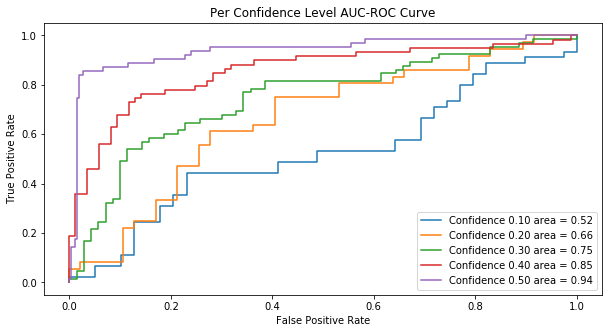

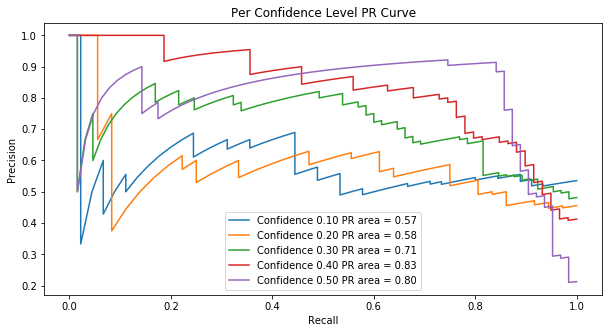

In [14]:
prec_array = []
recall_array = []
area_array_pr = []
area_array_roc = []
conf_array = []
fpr_array =[]
tpr_array =[]


for i in range(5):
    if len(samples_per_conf_level[i])!=0:
        fpr, tpr, _ = roc_curve(samples_per_conf_level[i], preds_per_conf_level[i])
        area_array_roc.append(auc(fpr, tpr))
        fpr_array.append(fpr)
        tpr_array.append(tpr)
        precision, recall, thresholds = precision_recall_curve(samples_per_conf_level[i], preds_per_conf_level[i])
        area_array_pr.append(auc(recall,precision))
        prec_array.append(precision)
        recall_array.append(recall)
        conf_array.append(i+1)


plt.figure(figsize=(10,5))
plt.title("Per Confidence Level AUC-ROC Curve")
for i in range(len(area_array_roc)):
    plt.plot(fpr_array[i], tpr_array[i], label='Confidence {:.2f} area = {:.2f}'.format(conf_array[i]*0.1, area_array_roc[i]))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()        
        
        

plt.figure(figsize=(10,5))
plt.title("Per Confidence Level PR Curve")
for i in range(len(area_array_pr)):
    plt.plot(recall_array[i], prec_array[i], label='Confidence {:.2f} PR area = {:.2f}'.format(conf_array[i]*0.1, area_array_pr[i]))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()